# Test on synthetic data

We evaluate the performance of the gridder on synthetic data produced by a visco-elastic model of the San Andreas Fault. We extract random samples from the model grid and try to reconstruct the original grid using our interpolation method. We include a region with denser sampling around the sourther portion of the fault to simulate real world data, which is irregularly sampled.

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D
from vectorspline3d.utils import sample_from_grid

## Load the 3-component synthetic grid

The synthetic grid is stored in a netCDF file with all 3 components included. This grid is a subsection of the original model data.

In [2]:
grid = xr.open_dataset("../../data/synthetic-san-andreas-2017.nc")
grid

<xarray.Dataset>
Dimensions:         (easting: 180, northing: 360)
Coordinates:
  * easting         (easting) float64 300.2 302.8 305.2 ... 742.8 745.2 747.8
  * northing        (northing) float64 100.2 102.8 105.2 ... 992.8 995.2 997.8
Data variables:
    east_velocity   (northing, easting) float32 ...
    north_velocity  (northing, easting) float32 ...
    up_velocity     (northing, easting) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdcut
    history:      grdcut xvel_2017.grd -Gxvel_2017c.grd -R0/1000/0/1700
    description:  
    GMT_version:  5.4.2 (r18461) [64-bit]
    node_offset:  1

Extract some useful values from the grid, like grid spacing, region, and coordinates. We'll use these values later on.

In [3]:
region = vd.get_region((grid.easting, grid.northing))
spacing = (grid.easting.values[1] - grid.easting.values[0], 
           grid.northing.values[1] - grid.northing.values[0])
grid_coords = np.meshgrid(grid.easting, grid.northing)
# We need the underlying numpy arrays ("values") because the computational core (numba) 
# doesn't play well with xarray.DataArray/
grid_components = (grid.east_velocity.values, grid.north_velocity.values, grid.up_velocity.values)
print(spacing)

(2.5, 2.5)


Create a function that plots our grid with vectors for the horizontal components and a pseudo-color map for the vertical.

In [4]:
def plot_data(data, ax=None, maxabs=3, every_arrow=4, quiver_scale=250, quiver_width=0.0015, size=50):
    if ax is None:
        plt.figure(figsize=(6, 15))
        ax = plt.subplot(111)
    cbargs = dict(orientation="horizontal", aspect=50, pad=0.05, label="vertical velocity (mm/yr)",
                  shrink=0.8)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(data.easting, data.northing, s=size, c=data.up_velocity,
                         vmin=-maxabs, vmax=maxabs, cmap="seismic")
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic",
                                         cbar_kwargs=cbargs)
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(easting=indexer, northing=indexer)
    ax.quiver(data.easting, data.northing, data.east_velocity, data.north_velocity, 
              scale=quiver_scale, width=quiver_width)
    ax.set_aspect("equal")
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")
    return ax

Plot the synthetic grid.

Text(0.5,1,'Synthetic data')

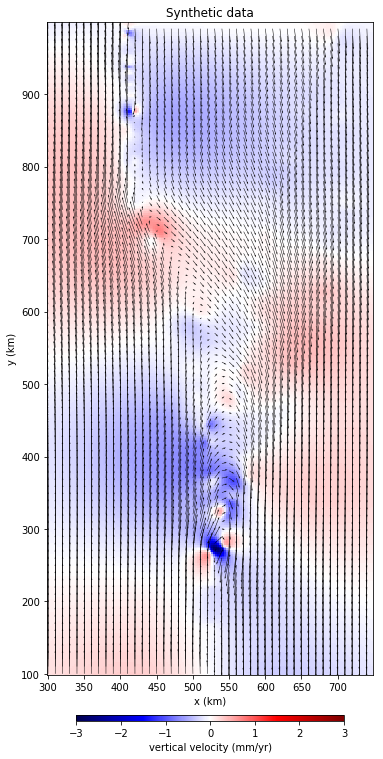

In [5]:
plot_data(grid).set_title("Synthetic data")

## Extract random samples

We'll test our gridder on random samples extracted from the synthetic grid.

Text(0.5,1,'Synthetic samples')

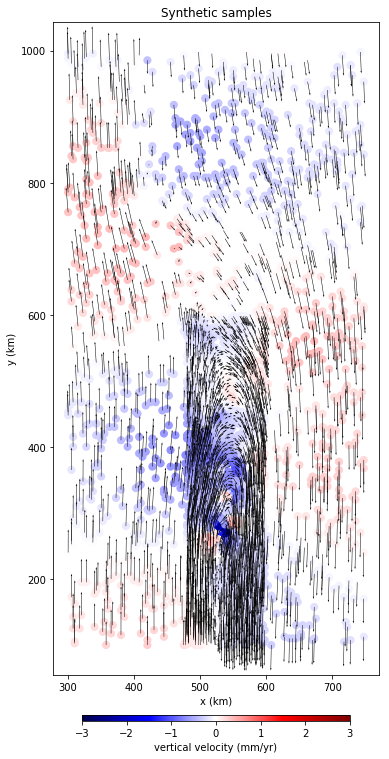

In [6]:
ndata = 3000
ncoarse = 1200
nfine = ndata - ncoarse
# First take a coarse sample
coarse = sample_from_grid(grid, size=ncoarse, random_state=0)
# and now a finner sample from a smaller section of the grid
fine = sample_from_grid(
    grid.sel(easting=slice(480, 600), northing=slice(None, 600)), 
    size=nfine, 
    random_state=0
)
data = pd.concat([coarse, fine])
coordinates = (data.easting, data.northing)
components = (data.east_velocity, data.north_velocity, data.up_velocity)

plot_data(data).set_title("Synthetic samples")

## Fit the spline

In [7]:
%%time
n = np.floor(np.sqrt(ndata))
force_coords = vd.grid_coordinates(vd.pad_region(region, 100), shape=(n, n))
force_coords = vd.BlockReduce(reduction=np.mean, spacing=spacing).filter(coordinates, np.ones(ndata))[0]
weights = (np.full(ndata, 0.0001), np.full(ndata, 0.0001), np.full(ndata, 1.0))
spline = VectorSpline3D(poisson=0.5, depth=30, damping=1e-2, force_coords=force_coords)
spline.fit(coordinates, components, weights=weights)

CPU times: user 37.7 s, sys: 10.1 s, total: 47.8 s
Wall time: 9.73 s


In [8]:
%%time
print("Score on sampled data:", spline.score(coordinates, components))
print("Score on grid data:", spline.score(grid_coords, grid_components))

Score on sampled data: 0.9885442074869436
Score on grid data: 0.9497516247531634
CPU times: user 5.51 s, sys: 43.7 ms, total: 5.56 s
Wall time: 1.2 s


## Regenerate the original grid

In [9]:
grid_spl = spline.grid(spacing=spacing, data_names=["east_velocity", "north_velocity", "up_velocity"])

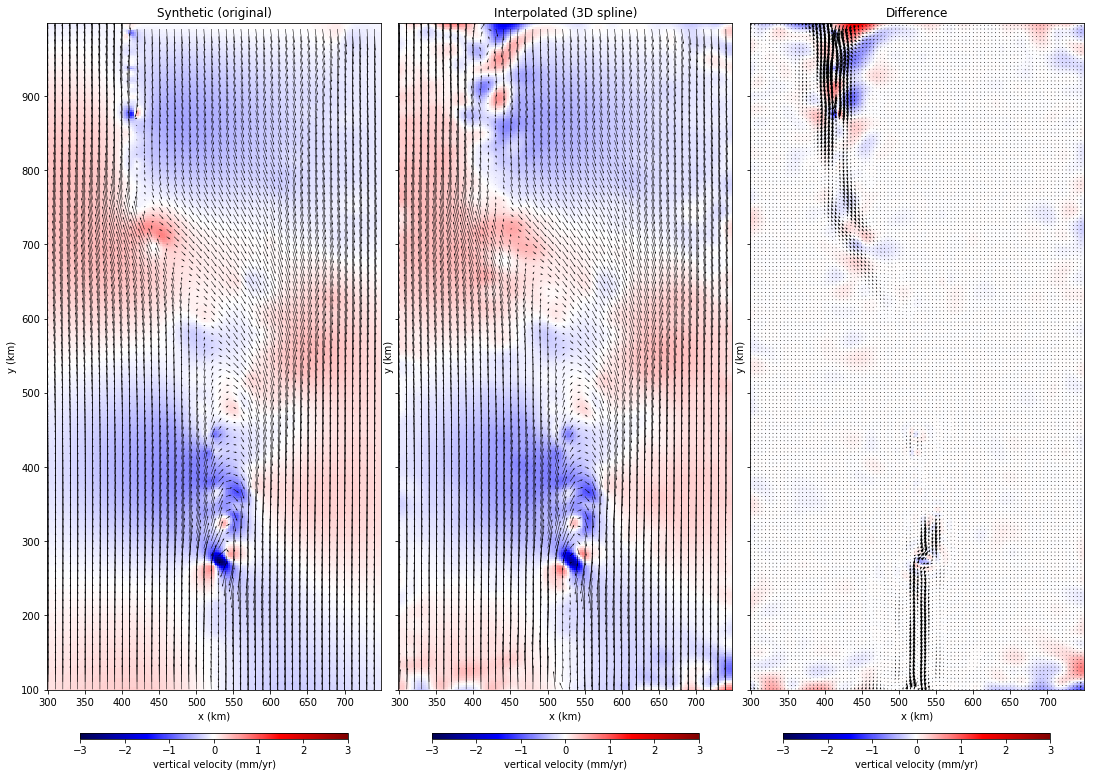

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 12), sharey=True)
plot_data(grid, ax=axes[0]).set_title("Synthetic (original)")
plot_data(grid_spl, ax=axes[1]).set_title("Interpolated (3D spline)")
plot_data(grid - grid_spl, ax=axes[2], quiver_width=0.003, every_arrow=2).set_title("Difference")
plt.tight_layout(pad=0)